<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/ELSI-DL-Bootcamp/blob/feat%23data_exploration/Data_Exploration_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Kaggle DeepSat SAT-6 Dataset (Dimitris) 
This notebook is for exploring the dataset we will deal with. The link to the dataset is here: DeepSat dataset

In [0]:
!pip install -U -q kaggle
!mkdir -p .kaggle
!mkdir -p ~/.kaggle

The first thing we should do is to get the dataset. 
The dataset is hosted at Kaggle, thus we can use the kaggle API to get the zip file.
The next cell installs the kaggle API

In [0]:
%%capture
import json
token = {"username":"your name","key":"your key"}
token = {"username":"dkatsios","key":"684d38a2e65bba3b1fcaecf462caae75"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

Downloading the data using Kaggle API

In [3]:
!kaggle datasets download -d crawford/deepsat-sat6 -p /content  # download
!unzip deepsat-sat6.zip && rm deepsat-sat6.zip  # unzip and delete .zip file
!rm sat-6-full.mat  # deletes the .mat file (useful in case of Matlab)
!ls  # show the content of the currenct directory (we will use the *.csv files)

100% 2.42G/2.42G [00:45<00:00, 35.2MB/s]
100% 2.42G/2.42G [00:46<00:00, 56.4MB/s]
Archive:  deepsat-sat6.zip
  inflating: X_test_sat6.csv         
  inflating: sat6annotations.csv     
  inflating: X_train_sat6.csv        
  inflating: sat-6-full.mat          
  inflating: y_train_sat6.csv        
  inflating: y_test_sat6.csv         
sample_data	     X_test_sat6.csv   y_test_sat6.csv
sat6annotations.csv  X_train_sat6.csv  y_train_sat6.csv


# Data Exploration (Mustafa)

Import packages

In [0]:
import os
import csv
import numpy as np
from imutils import paths
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

### Make a subset (small part of data)

- We make a small dataset  to have insight into  original one

In [0]:
# X_train = pd.read_csv('X_train_sat6.csv')
# y_train = pd.read_csv('y_train_sat6.csv')
!head -1000 X_train_sat6.csv > sample_X_train.csv
!head -1000 shuffled_y_train.csv > sample_y_train.csv

### Print current folder

In [9]:
from subprocess import check_output
print(check_output(["ls", "./"]).decode("utf8"))

sample_data
sample_X_train.csv
sample_y_train.csv
sat6annotations.csv
shuffled_y_train.csv
X_test_sat6.csv
X_train_sat6.csv
y_test_sat6.csv
y_train_sat6.csv



### Load dataset

In [10]:
X_train = pd.read_csv('sample_X_train.csv')
y_train = pd.read_csv('sample_y_train.csv')


print('X_train_shape:',X_train.values.shape)
print('y_train_shape:',y_train.values.shape)

X_train_shape: (999, 3136)
y_train_shape: (999, 6)


- Original images are in shape of (999, 28, 28, 4) --> (samples, height, width, channel) , but were given in (999, 3136)
- So we need to reshape them first to have a standard image format

### Reshape and check dimensions again

In [11]:
X_train_array = X_train.values.reshape((-1,28,28,4)).clip(0,255).astype(np.uint8)
y_train_array = y_train.values.getfield(dtype=np.int8)

print('X_train_shape:',X_train_array.shape)
print('y_train_shape:',y_train_array.shape)

X_train_shape: (999, 28, 28, 4)
y_train_shape: (999, 6)


- classes are seen in shape of (999,6) where 6 is index size of encoded labels
- therefore we should decode each label to count and visualize distribution of classes

### Decoding classes 

- Encoding Example:

In [12]:
import numpy as np
from keras.utils import to_categorical
data = np.array([1, 5, 3, 8])
data_encoded = to_categorical(data)
print(data)
print(data_encoded)

Using TensorFlow backend.


[1 5 3 8]
[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


- original labels given:

In [17]:
y_train.head()

0      int64
0.1    int64
0.2    int64
0.3    int64
1      int64
0.4    int64
dtype: object


- In order to decode values, we will use numpy's argmax function, which returns us the index of max value of each row

In [0]:
class_ = []

# we call here y_train as dataframe, not y_train_array

for inx,cols in y_train.iterrows():
  
    #print(cols.to_list())
    class_.append(np.argmax(cols.to_list()))
    
# make DataFrame 
y_train = pd.DataFrame(class_,columns=['class_name'])

### Check number  of classes 
- classes : (0,1,2,3,4,5)

In [0]:
y_train['class_name'].value_counts()

5    375
1    211
3    174
2    161
0     54
4     24
Name: class_name, dtype: int64

- Alternativly we can use 'Counter' function as well

In [0]:
from collections import Counter

Counter(class_).most_common()

[(5, 375), (1, 211), (3, 174), (2, 161), (0, 54), (4, 24)]

### Visualize class distribution

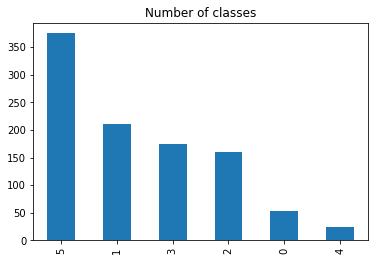

In [0]:
# y_train.plot(kind='hist',legend=True)
y_train.class_name.value_counts().plot(kind='bar',title='Number of classes')
# plt.tight_layout()
# plt.xticks(range(0,6), y_train.index, fontsize=12)
plt.show()

- As it is seen on the graph, Class '5' has more and '4' has less samples

## Undersampling

- To balance our dataset, we can reduce major classes to minor ones in number

In [0]:
grouped = y_train.groupby('class_name')
y_train_under_sampled = grouped.apply(lambda x: x.sample(grouped.size().min()).reset_index(drop=True))
Counter(y_train_under_sampled['class_name'].values).most_common()

[(0, 24), (1, 24), (2, 24), (3, 24), (4, 24), (5, 24)]

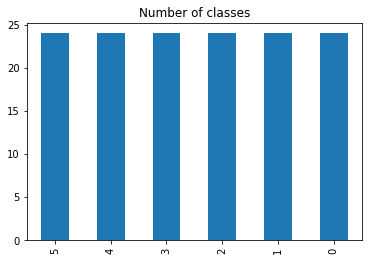

In [0]:
y_train_under_sampled.class_name.value_counts().plot(kind='bar',title='Number of classes')
plt.show()

## Over-sampling

- Oversampling refers augmentation when handling with images
- Following example can be considered as for numerical data over-sampling, since we can fill new samples by mean and variance 

### Let's save first counts for each class 

In [0]:
class_5,class_1,class_3,class_2,class_0,class_4 = y_train.class_name.value_counts()

### Then let's seperate our dataset into every class to apply over-sampling seperately 

In [0]:
y_train_0 = y_train.class_name[y_train.class_name == 0]
y_train_1 = y_train.class_name[y_train.class_name == 1]
y_train_2 = y_train.class_name[y_train.class_name == 2]
y_train_3 = y_train.class_name[y_train.class_name == 3]
y_train_5 = y_train.class_name[y_train.class_name == 5]
y_train_4 = y_train.class_name[y_train.class_name == 4]


### Applying over-sampling for the Class '0' and Class '4' by referring Class '2'

In [0]:
y_train_0 = y_train_0.sample(class_2,replace=True)
y_train_4 = y_train_4.sample(class_2,replace=True)

y_train_over_sampled = pd.concat([y_train_0,y_train_1,y_train_2,y_train_3,y_train_4,y_train_5],axis=0)

### Visualize again

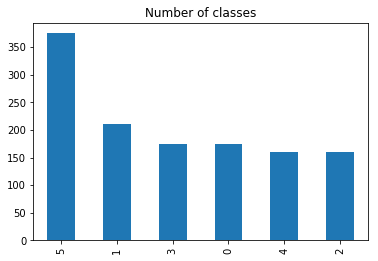

In [0]:

y_train_over_sampled.value_counts().plot(kind='bar',title='Number of classes')
plt.show()

## Image Augmentation

- As for images, we use typical image processing approaches such as flipping, rotating, padding etc.

In [0]:

chosen_idx = np.random.choice(100, replace=False, size=50)

images = X_train_array[chosen_idx]
images.shape

(50, 28, 28, 4)

In [0]:
image = images[0]

### Horizontal Flip

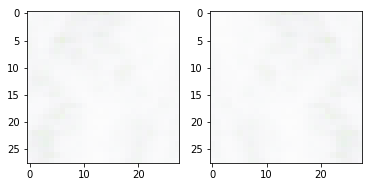

In [0]:
def horizontal_flip(image):
  
    image_hor_flip = image[:, ::-1, :]
    
    plt.subplot(121)
    plt.imshow(image)
        
    plt.subplot(122)
    plt.imshow(image_hor_flip)
    plt.show()
  
horizontal_flip(image)

### Vertical Flip

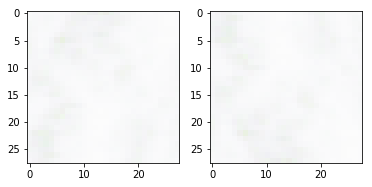

In [0]:
def vertical_flip(image, rate=0.5):
  
    if np.random.rand() < rate:
      
      image_ver_flip = image[::-1, :, :]  
  
      plt.subplot(121)
      plt.imshow(image)

      plt.subplot(122)
      plt.imshow(image_ver_flip)
      plt.show()
    
vertical_flip(image)   

### Random Flip

### Random Rotate

In [0]:
from scipy.ndimage.interpolation import rotate

def random_rotation(image, angle_range=(0, 180)):
  
    height, width, _ = image.shape
    angle = np.random.randint(*angle_range)
    image_rotate = rotate(image, angle)
    image_rotate = imresize(image_rotate, (height, width))
    
    plt.subplot(121)
    plt.imshow(image)

    plt.subplot(122)
    plt.imshow(image_rotate)
    plt.show()

random_rotation(image, angle_range=(0, 180))

NameError: ignored

# Data Visualization (Alisher)

In [0]:
import csv
import pandas as pd
import numpy as np
from numpy.random import randint, random, normal
import matplotlib.pyplot as plt
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [0]:
EPOCHS = 10
BATCH_SIZE = 64
IMG_SHAPE = 28, 28, 4

TRAIN_NUM, TEST_NUM = 324000, 81000  # from the dataset site
train_steps, test_steps = TRAIN_NUM // BATCH_SIZE, TEST_NUM // BATCH_SIZE

def get_gen(x_csv_path, y_csv_path, batch_size=BATCH_SIZE,
            img_shape=IMG_SHAPE, labels_num=6, augment=False):
  """
  Return a generator.
  
  This function returns a data generator. Every time the generator is called
  it yields one batch of pairs (images, labels).
  """
  xf, yf = open(x_csv_path), open(y_csv_path)
  x_reader, y_reader = csv.reader(xf, delimiter=","), csv.reader(yf, delimiter=",")

  while True:
    imgs = np.zeros((batch_size, *img_shape))
    labels = np.zeros((batch_size, labels_num))

    for i in range(batch_size):

      try:
        x_line, y_line = next(x_reader), next(y_reader)
      except:
        # this except clause resets the line readers when they reach the end of the files
        xf.close()
        yf.close()
        xf, yf = open(x_csv_path), open(y_csv_path)
        x_reader, y_reader = csv.reader(xf, delimiter=","), csv.reader(yf, delimiter=",")
        x_line, y_line = next(x_reader), next(y_reader)

      img = np.reshape(list(map(int, x_line)), img_shape)
      img = preprocess_img(img, augment)
      imgs[i] = img

      label = np.array(list(map(int, y_line)))
      labels[i] = label

    yield imgs, labels


def preprocess_img(img, augment=False):
  """
  Preprocess the images.
  
  Takes as input an image and a boolean value (augment).
  The standard preprocess includes only division by 255.0 (which maps from [0, 255] to [0.0, 1.0]).
  """
  img = img / 255.0
  if augment:
    img = augment_img(img)
  
  return img


def augment_img(img):
  """
  Augment an image.
  
  Image augmentation is useful in order to avoid overfitting.
  This function adds random (normal) noise and randomly flip and/or rotate each image.
  """
  # add noise
  gauss = normal(0, 0.05, img.shape)
  img = img + gauss
  img = np.clip(img, 0, 1)

  # rotate 0/90/180/270
  img = np.rot90(img, randint(0, 3), axes=(0, 1))

  # flip/no-flip orizontaly/vertical
  if random() < 0.5: img = img[:, ::-1, :]
  if random() < 0.5: img = img[::-1, :, :]

  return img

In [0]:
test_gen = get_gen('X_test_sat6.csv', 'y_test_sat6.csv', 3000)
label_names = list(pd.read_csv('sat6annotations.csv', header=None)[0])

In [0]:
imgs, labels_one_hot = next(test_gen)
labels = np.argmax(labels_one_hot, axis=1)

In [0]:
labels = np.argmax(labels_one_hot, axis=1)
class1 = np.where(labels)

In [0]:
imgs = imgs.reshape(3000, -1)

In [24]:
feat_cols = ['pixel'+str(i) for i in range(imgs.shape[1])]
df = pd.DataFrame(imgs,columns=feat_cols)
df['y'] = labels
df['label'] = df['y'].apply(lambda i: str(i))
imgs, label = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (3000, 3138)


In [0]:
np.random.seed(42)
rndperm = np.random.permutation(3000)

In [26]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.65709377 0.1736011  0.01669412]


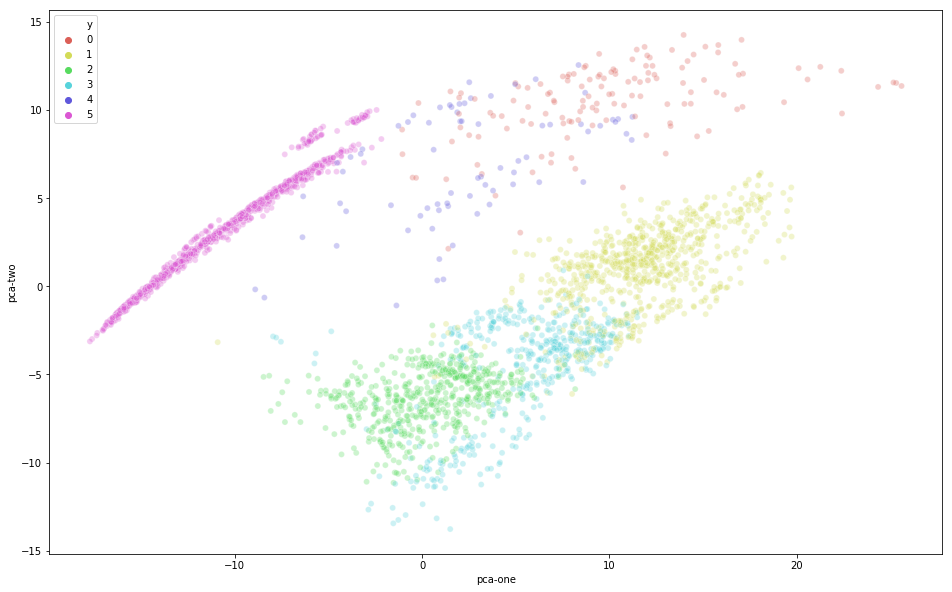

In [27]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 6),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

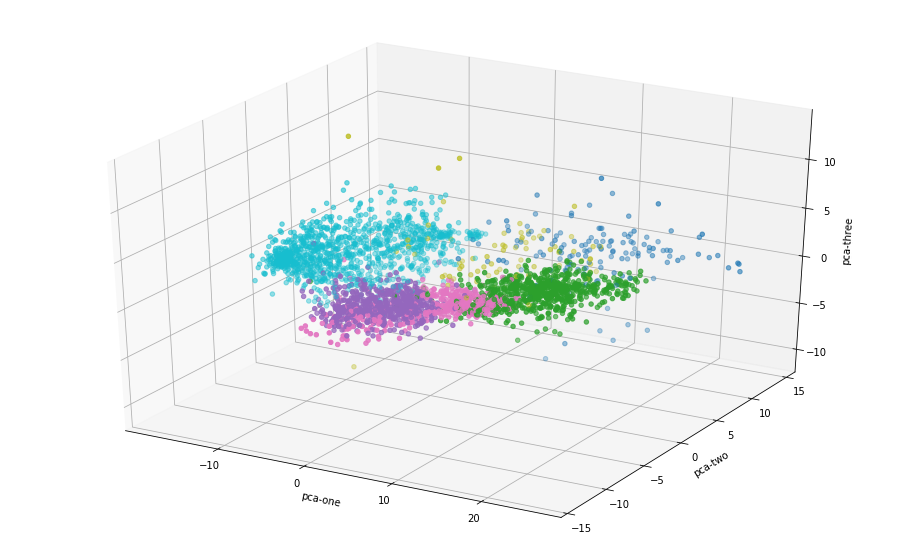

In [28]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [29]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.575s...
[t-SNE] Computed neighbors for 3000 samples in 53.709s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 1.418822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.111961
[t-SNE] KL divergence after 300 iterations: 1.487672
t-SNE done! Time elapsed: 63.95214629173279 seconds


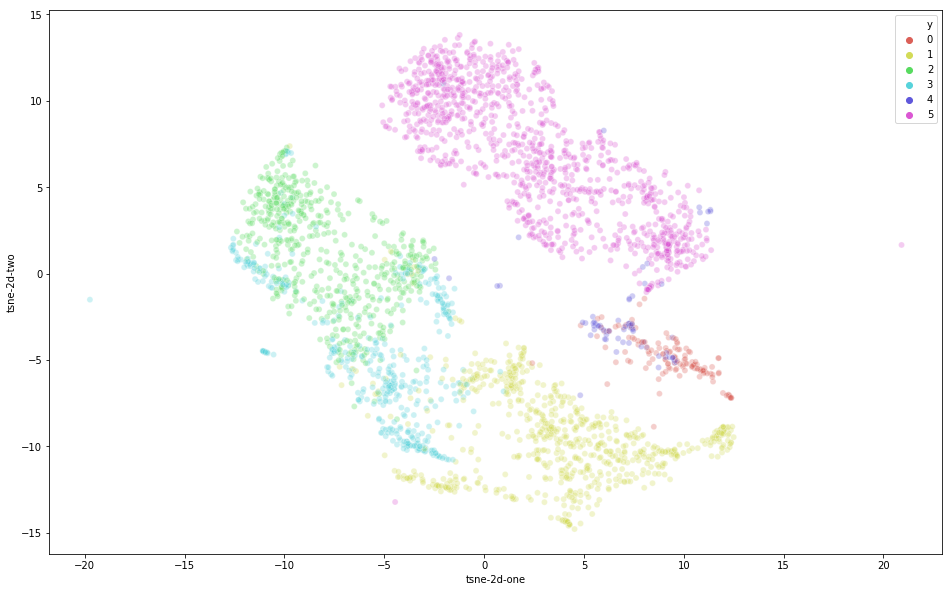

In [30]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 6),
    data=df_subset,
    legend="full",
    alpha=0.3
)